# SK하이닉스 리더십 관련 뉴스 분석

이 노트북에서는 SK하이닉스의 리더십 관련 뉴스 데이터를 분석하여 주요 토픽과 키워드를 추출합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Mecab
from collections import Counter
import re
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from itertools import combinations
from sklearn.decomposition import LatentDirichletAllocation
# 기존 import 문을 아래와 같이 변경
import pyLDAvis
import pyLDAvis.gensim_models  # gensim 모델을 사용하는 경우
# 또는
import pyLDAvis.lda_model  # 직접 구현한 LDA 모델을 사용하는 경우
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df = pd.read_csv('data/skhynix/leadership_news.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"데이터 크기: {len(df)}")
df.head()

데이터 크기: 120


,title,url,date,category,tags,content
0,[2025 신임임원 인터뷰 5편] SK하이닉스 HBM사업기획 최준용 부사장 “HBM...,https://news.skhynix.co.kr/2025-new-executive-...,2025-04-07,CULTURE &,"HBM, 사업기획, 신임임원 인터뷰","AI 기술의 발전과 함께 이를 뒷받침하는 고대역폭메모리, HBM의 비약적인 성장은 ..."
1,[2025 신임임원 인터뷰 4편] SK하이닉스 SKMS&Growth 이송만 부사장 ...,https://news.skhynix.co.kr/2025-new-executive-...,2025-03-31,CULTURE &,"HRD, SKHU, SKMS, 신임임원 인터뷰",SK하이닉스 경영의 중심에는 ‘SKMS(SK Management System)’가 ...
2,"SK하이닉스 장태수 부사장, 제52회 상공의 날 대통령 표창 수상 “세계 최초 10...",https://news.skhynix.co.kr/award-on-commerce-a...,2025-03-20,CULTURE &,"1cDDR5, D램, 대통령표창, 미세공정, 상공의날",제52회 상공의 날 기념 행사에서 대통령 표창을 받은 SK하이닉스 장태수 부사장(미...
3,"SK하이닉스, GTC 2025서 독보적인 AI 메모리 기술 리더십 선봬\n...의 ...",https://news.skhynix.co.kr/gtc-2025/,2025-03-19,TECH & AI &,"AI, D램, eSSD, GTC, HBM, 낸드플래시",SK하이닉스가 3월 17일부터 21일(현지 시간)까지 미국 캘리포니아주 새너제이(S...
4,[2025 신임임원 인터뷰 2편] SK하이닉스 경영분석 엄재광 부사장 “균형 잡힌 ...,https://news.skhynix.co.kr/2025-new-executive-...,2025-03-10,CULTURE &,"경영분석, 신임임원 인터뷰","SK하이닉스는 지난 2024년, 창사 이래 최대 실적을 기록하며 글로벌 AI 메모리..."


## 1. 도메인 특화 키워드 사전 생성

반도체/리더십 도메인의 전문 용어와 중요 키워드를 추출합니다.

In [2]:
# 기본 도메인 키워드 사전
domain_keywords = {
    # 반도체 산업 관련
    '반도체': ['메모리', 'HBM', 'DDR5', 'NAND', 'DRAM', 'D램', '파운드리', 'TSMC', '인텔', '삼성전자', 'SK하이닉스',
            '웨이퍼', '칩', '팹리스', '패키징', '마이크론', '퀄컴', 'AMD', '엔비디아', '아마존', '구글', '애플'],
    
    # 리더십 관련
    '리더십': ['CEO', '사장', '대표이사', '회장', '경영진', '임원', '수석', '총괄', '책임자', '이사',
            '경영', '전략', '비전', '혁신', '변화', '성과', '성장', '개발', '연구', '투자'],
    
    # 기술 관련
    '기술': ['AI', '인공지능', '빅데이터', '클라우드', '5G', '6G', 'IoT', '자율주행', '메타버스',
           '양자컴퓨팅', '로봇', '자동화', '스마트팩토리', '디지털트랜스포메이션'],
    
    # 비즈니스 관련
    '비즈니스': ['매출', '영업이익', '투자', 'M&A', '합작', '협력', '시장점유율', '경쟁력', '성장률',
              '주가', '시가총액', '배당', '주주가치']
}

# Mecab 초기화
mecab = Mecab()

# 제거할 품사 태그
remove_pos = {'J', 'E', 'V', 'X', 'S', 'U', 'I', 'VCP', 'VCN'}

# 영어-한글 혼합 형태 보존을 위한 패턴
mixed_pattern = re.compile(r'[A-Za-z]+[가-힣]+|[가-힣]+[A-Za-z]+')

# N-gram 추출을 위한 함수
def extract_ngrams(text, n=2):
    if not isinstance(text, str):
        return []
    
    # 영어-한글 혼합 형태 보존
    mixed_words = set(mixed_pattern.findall(text))
    
    # 형태소 분석
    pos = mecab.pos(text)
    
    # 의미 있는 명사만 추출
    nouns = []
    for word, pos_tag in pos:
        # 영어-한글 혼합 형태는 보존
        if word in mixed_words:
            nouns.append(word)
            continue
            
        # 일반 명사만 추출 (조사, 어미 등 제외)
        if pos_tag.startswith('N') and pos_tag not in remove_pos:
            # 한 글자 한자어 제외
            if not (len(word) == 1 and '\u4e00' <= word <= '\u9fff'):
                nouns.append(word)
    
    # N-gram 생성
    if len(nouns) < n:
        return []
    
    ngrams = []
    for i in range(len(nouns) - n + 1):
        ngram = tuple(nouns[i:i+n])
        ngrams.append(ngram)
    
    return ngrams

# 기사 내용에서 N-gram 추출
all_ngrams = []
for content in df['content']:
    all_ngrams.extend(extract_ngrams(content))

# N-gram 빈도 계산
ngram_freq = Counter(all_ngrams)

# 상위 N-gram 출력
print("자주 등장하는 2-gram:")
for ngram, freq in ngram_freq.most_common(20):
    print(f"{' '.join(ngram)}: {freq}")

# 도메인 키워드 사전 업데이트
for category, keywords in domain_keywords.items():
    print(f"\n{category} 관련 키워드:")
    for keyword in keywords:
        count = sum(1 for content in df['content'] if isinstance(content, str) and keyword in content)
        print(f"{keyword}: {count}회 등장")

자주 등장하는 2-gram:
관련 기사: 130
제품 개발: 108
기술 개발: 106
데이터 센터: 100
수 것: 87
낸드 플래시: 82
협 력사: 79
세계 최초: 71
지속 가능: 71
메모리 반도체: 66
데이터 처리: 62
키 징: 61
미래 기술: 60
이 천: 60
기술 리더십: 54
플랫 폼: 52
구성원 행복: 51
지식 블로그: 50
년 간: 48
메모리 솔루션: 48

반도체 관련 키워드:
메모리: 78회 등장
HBM: 57회 등장
DDR5: 34회 등장
NAND: 27회 등장
DRAM: 32회 등장
D램: 59회 등장
파운드리: 9회 등장
TSMC: 6회 등장
인텔: 16회 등장
삼성전자: 3회 등장
SK하이닉스: 119회 등장
웨이퍼: 26회 등장
칩: 41회 등장
팹리스: 2회 등장
패키징: 15회 등장
마이크론: 3회 등장
퀄컴: 2회 등장
AMD: 1회 등장
엔비디아: 9회 등장
아마존: 2회 등장
구글: 3회 등장
애플: 6회 등장

리더십 관련 키워드:
CEO: 15회 등장
사장: 47회 등장
대표이사: 10회 등장
회장: 9회 등장
경영진: 13회 등장
임원: 31회 등장
수석: 4회 등장
총괄: 17회 등장
책임자: 3회 등장
이사: 17회 등장
경영: 41회 등장
전략: 44회 등장
비전: 38회 등장
혁신: 67회 등장
변화: 61회 등장
성과: 86회 등장
성장: 73회 등장
개발: 105회 등장
연구: 63회 등장
투자: 36회 등장

기술 관련 키워드:
AI: 63회 등장
인공지능: 23회 등장
빅데이터: 12회 등장
클라우드: 11회 등장
5G: 7회 등장
6G: 22회 등장
IoT: 4회 등장
자율주행: 9회 등장
메타버스: 1회 등장
양자컴퓨팅: 0회 등장
로봇: 3회 등장
자동화: 11회 등장
스마트팩토리: 1회 등장
디지털트랜스포메이션: 0회 등장

비즈니스 관련 키워드:
매출: 16회 등장
영업이익: 7회 등장
투자: 36회 등장
M&A: 4회 등장
합작: 4회 등장
협력: 55회 등장
시장점유율: 4

## 2. 개선된 텍스트 전처리

도메인 특화 키워드 사전을 활용한 전처리

In [3]:
# 모든 도메인 키워드를 하나의 리스트로 통합
all_domain_keywords = [keyword for keywords in domain_keywords.values() for keyword in keywords]

def preprocess_text(text):
    if pd.isna(text):
        return ''
    
    # 도메인 키워드 보존
    for keyword in all_domain_keywords:
        text = text.replace(keyword, f' {keyword} ')
    
    # 영어-한글 혼합 형태 보존
    mixed_words = set(mixed_pattern.findall(text))
    
    # 특수문자 제거 (단, 도메인 키워드와 영어-한글 혼합 형태는 보존)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # 형태소 분석
    pos = mecab.pos(text)
    
    # 의미 있는 단어 추출
    words = []
    for word, pos_tag in pos:
        # 영어-한글 혼합 형태는 보존
        if word in mixed_words:
            words.append(word)
            continue
            
        # 도메인 키워드는 보존
        if word in all_domain_keywords:
            words.append(word)
            continue
            
        # 일반 명사, 형용사, 동사 추출 (조사, 어미 등 제외)
        if pos_tag in ['NNG', 'NNP', 'VA', 'VV'] and pos_tag not in remove_pos:
            # 한 글자 한자어 제외
            if not (len(word) == 1 and '\u4e00' <= word <= '\u9fff'):
                words.append(word)
    
    return ' '.join(words)

# 텍스트 전처리 적용
df['processed_content'] = df['content'].apply(preprocess_text)

# 샘플 출력
print("전처리된 텍스트 샘플:")
print(df['processed_content'].iloc[0][:200])

# 도메인 키워드 등장 빈도 확인
keyword_freq = {}
for keyword in all_domain_keywords:
    freq = sum(1 for text in df['processed_content'] if keyword in text)
    if freq > 0:
        keyword_freq[keyword] = freq

print("\n도메인 키워드 등장 빈도:")
for keyword, freq in sorted(keyword_freq.items(), key=lambda x: x[1], reverse=True):
    print(f"{keyword}: {freq}회")

전처리된 텍스트 샘플:
AI 기술 발전 뒷받침 대역폭 메모리 HBM 비약 성장 지난해 하이닉스 달성 사상 최대 실적 기여 업계 하이닉스 성장 매출 증가 넘 AI 시대 패러다임 주도 변화 신호탄 평가 흐름 반영 하이닉스 최근 조직 개편 단행 젊 혁신 리더십 강화 최준용 부 사장 HBM 사업 기획 총괄 임원 선임 업계 주목 받 모바일 램 상품 기획 팀장 거치 HBM 사업 기획 담당 

도메인 키워드 등장 빈도:
개발: 105회
메모리: 78회
성과: 78회
성장: 73회
혁신: 67회
경쟁력: 66회
연구: 63회
AI: 63회
변화: 61회
HBM: 57회
협력: 55회
사장: 47회
전략: 44회
칩: 41회
경영: 41회
비전: 38회
투자: 36회
DRAM: 32회
임원: 31회
NAND: 27회
웨이퍼: 26회
인공지능: 23회
총괄: 17회
인텔: 16회
매출: 16회
CEO: 15회
이사: 15회
클라우드: 11회
파운드리: 9회
회장: 9회
TSMC: 6회
애플: 6회
수석: 4회
IoT: 4회
합작: 4회
시가총액: 4회
삼성전자: 3회
구글: 3회
책임자: 3회
퀄컴: 2회
아마존: 2회
로봇: 2회
AMD: 1회
자동화: 1회
주가: 1회
배당: 1회


## 3. 키워드 분석 및 시각화

도메인 특화 키워드를 포함한 분석

In [4]:
def get_top_keywords(texts, n=20):
    words = ' '.join(texts).split()
    # 한 글자 단어 제거
    words = [word for word in words if len(word) > 1]
    return Counter(words).most_common(n)

# 전체 기간 키워드
all_keywords = get_top_keywords(df['processed_content'])
print("전체 기간 주요 키워드:")
for word, count in all_keywords:
    print(f"{word}: {count}")

# 연도별 키워드
df['year'] = df['date'].dt.year
for year in sorted(df['year'].unique()):
    year_texts = df[df['year'] == year]['processed_content']
    year_keywords = get_top_keywords(year_texts, n=10)
    print(f"\n{year}년 주요 키워드:")
    for word, count in year_keywords:
        print(f"{word}: {count}")

전체 기간 주요 키워드:
하이닉스: 1317
기술: 1104
개발: 870
제품: 720
HBM: 637
구성원: 629
AI: 592
반도체: 578
메모리: 569
회사: 434
사장: 424
데이터: 422
기업: 373
시장: 364
업무: 362
담당: 345
성능: 321
고객: 287
조직: 284
미래: 279

2015년 주요 키워드:
바딘: 36
연구: 34
기술: 29
개발: 23
대학: 22
제품: 19
하이닉스: 17
인증: 17
인텔: 16
책임: 16

2016년 주요 키워드:
품질: 55
보증: 36
업무: 31
하이닉스: 26
반도체: 23
리더: 20
고객: 18
감독: 18
제품: 17
선수: 16

2017년 주요 키워드:
수율: 31
하이닉스: 28
낸드: 26
플래시: 26
기술: 23
목표: 22
반도체: 18
이광호: 18
기정: 18
노력: 14

2018년 주요 키워드:
반도체: 77
중국: 51
기업: 32
하이닉스: 24
수석: 23
기술: 22
세계: 20
미국: 20
메모리: 20
프로젝트: 20

2019년 주요 키워드:
기술: 86
하이닉스: 56
구성원: 44
장비: 41
반도체: 36
미래: 35
개발: 34
연구: 29
칠러: 28
명장: 27

2020년 주요 키워드:
하이닉스: 128
구성원: 95
반도체: 89
제품: 66
담당: 61
기업: 52
과정: 48
행복: 48
기술: 47
고객: 46

2021년 주요 키워드:
하이닉스: 231
업무: 145
분석: 138
구성원: 137
기업: 121
기술: 102
경영: 100
담당: 96
환경: 88
관리: 83

2022년 주요 키워드:
하이닉스: 131
개발: 88
구성원: 81
기술: 71
환경: 55
반도체: 52
담당: 51
프로그램: 47
협력: 47
데이터: 43

2023년 주요 키워드:
하이닉스: 246
기술: 233
개발: 230
제품: 185
HBM: 179
데이터: 150
메모리: 119
성능: 100
속도: 96
AI:

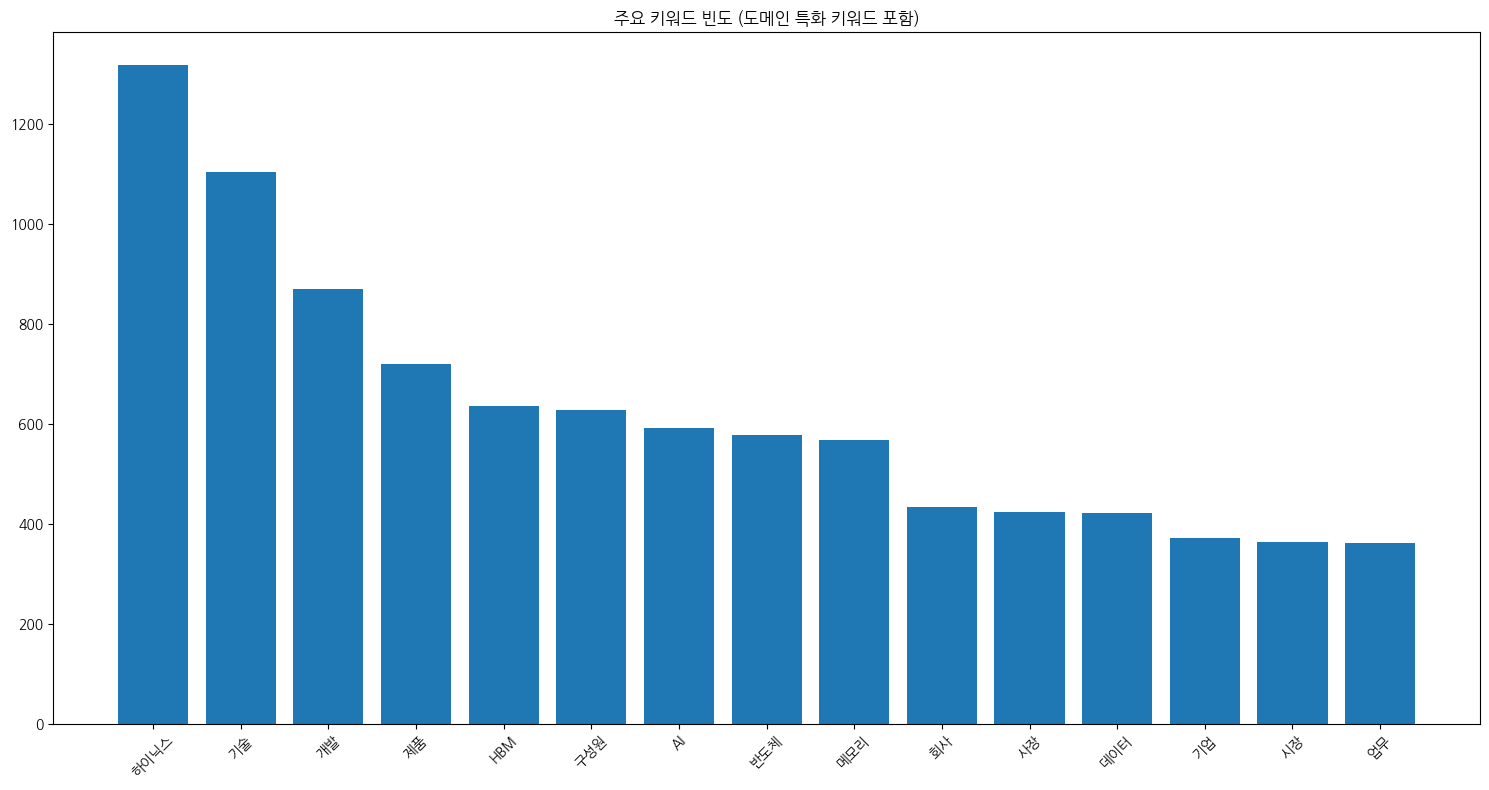

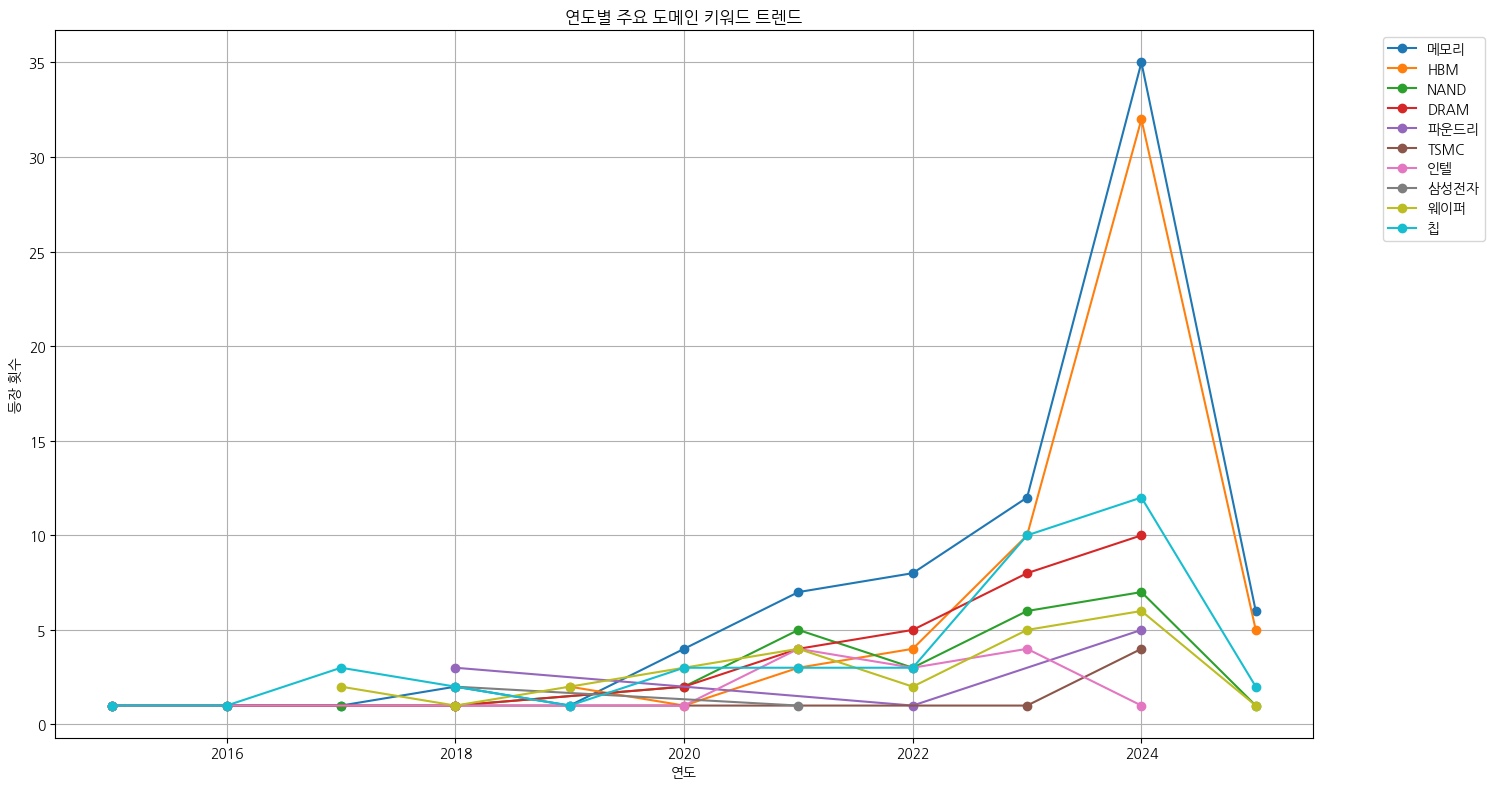

In [5]:
# 키워드 빈도 시각화
plt.figure(figsize=(15, 8))
keywords = [word for word, _ in all_keywords[:15]]
counts = [count for _, count in all_keywords[:15]]
plt.bar(keywords, counts)
plt.xticks(rotation=45)
plt.title('주요 키워드 빈도 (도메인 특화 키워드 포함)')
plt.tight_layout()
plt.show()

# 연도별 주요 도메인 키워드 트렌드
plt.figure(figsize=(15, 8))
for keyword in list(keyword_freq.keys())[:10]:  # 상위 10개 키워드만 선택
    yearly_counts = df[df['processed_content'].str.contains(keyword, na=False)].groupby('year').size()
    plt.plot(yearly_counts.index, yearly_counts.values, marker='o', label=keyword)

plt.title('연도별 주요 도메인 키워드 트렌드')
plt.xlabel('연도')
plt.ylabel('등장 횟수')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. 연도별 토픽 분석

LDA를 사용한 연도별 토픽 모델링

In [7]:
def perform_topic_modeling(texts, n_topics=5, n_top_words=10):
    # 문서-단어 행렬 생성
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    doc_term_matrix = vectorizer.fit_transform(texts)
    
    # LDA 모델 학습
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_output = lda_model.fit_transform(doc_term_matrix)
    
    # 토픽별 주요 단어 추출
    feature_names = vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
        topics.append(top_words)
    
    return topics, lda_output, lda_model, doc_term_matrix, vectorizer

# 연도별 토픽 분석
for year in sorted(df['year'].unique()):
    year_texts = df[df['year'] == year]['processed_content']
    if len(year_texts) < 10:  # 데이터가 너무 적은 연도는 건너뛰기
        continue
        
    print(f"\n{year}년 토픽 분석:")
    topics, _, lda_model, doc_term_matrix, vectorizer = perform_topic_modeling(year_texts)
    
    for i, topic in enumerate(topics):
        print(f"토픽 {i+1}: {', '.join(topic)}")
    
    # pyLDAvis 시각화
    vis = pyLDAvis.lda_model.prepare(
        lda_model, 
        doc_term_matrix, 
        vectorizer,
        mds='tsne'
    )
    pyLDAvis.display(vis)


2020년 토픽 분석:
토픽 1: 구성원, 제품, 담당, 행복, 고객, 품질, 업무, 개발, 기술, 변화
토픽 2: 반도체, 과정, 인재, 고려, 학생, 미래, 교육, 채용, 역량, 제공
토픽 3: 질문, 자신, 경험, 전공, 관련, 사람, 생각, 평가, 중요, 안전
토픽 4: 제품, 사람, 개발, 낸드, 생각, 검증, 팀장, 솔루션, 서로, 웃음
토픽 5: 지식, 기업, 관련, 한국, 분야, 중요, 담당, 역량, 경쟁력, 경험

2021년 토픽 분석:
토픽 1: 분석, 담당, 기술, 장비, 업무, 구성원, 조직, 개발, 제품, 효율
토픽 2: 경영, 기업, 투자, 가능, 사회, 관련, 지속, 리스크, 보고서, 변화
토픽 3: 지식, 블로그, 관리, 업무, 정보, 환경, 구성원, 기업, 활용, 세계
토픽 4: 업무, 멘토, 구성원, 법인, 고객, 제품, 공정, 행복, 중요, 개발
토픽 5: 주인공, 부담, 결실, 생태계, 마케팅, 토론, 존중, 찾아가, 강의, 위상

2022년 토픽 분석:
토픽 1: 개발, 프로그램, 환경, 컨설팅, 협력, 관리, 건강, 데이터, 서버, 제품
토픽 2: 반도체, 구성원, 과정, 메모리, 성장, hbm, 성능, 지원, 진행, 교육
토픽 3: 메모리, 솔루션, 요구, 데이터, 기기, 혁신, 반도체, 지속, 장치, 충족
토픽 4: 담당, 리더, 구성원, 업무, 전략, 분석, 조직, 올해, 역량, 역할
토픽 5: 개발, 구성원, 목표, 경영, 담당, 가능, 보고서, 지속, 기업, 변화

2023년 토픽 분석:
토픽 1: 개발, 제품, hbm, 기술, 속도, 성능, 모바일, 시장, 최고, 성공
토픽 2: 구성원, 업무, 협력, 연구, 측정, 글로벌, 환경, 기업, 회사, 해외
토픽 3: 메모리, 데이터, ai, 기술, 제품, 성능, 개발, 솔루션, hbm, 효율
토픽 4: 기술, 본딩, 연결, 범프, 와이어, 적용, 하이브리드, hbm, 제품, 개발
토픽 5: 데이터, hbm, 센터, 개발, 반도체, 낸드, 플래시, 제품, 적용, 대


연도별 토픽 분석을 시작합니다...

2015년도 토픽 분석:
상위 20개 토픽:
바딘: 36회
연구: 34회
기술: 29회
개발: 23회
대학: 22회
제품: 19회
인증: 17회
인텔: 16회
책임: 16회
세계: 15회
사람: 15회
최초: 15회
과정: 14회
분야: 13회
트랜지스터: 13회
리더십: 12회
시장: 12회
물리학자: 11회
데이터: 11회
셀: 11회

2016년도 토픽 분석:
상위 20개 토픽:
품질: 55회
보증: 36회
업무: 31회
반도체: 23회
리더: 20회
고객: 18회
감독: 18회
제품: 17회
선수: 16회
핸드볼: 15회
책임: 14회
문제: 14회
개발: 13회
회사: 13회
경기: 11회
양산: 10회
지속: 10회
중요: 10회
후배: 10회
직무: 9회

2017년도 토픽 분석:
상위 20개 토픽:
수율: 31회
낸드: 26회
플래시: 26회
기술: 23회
목표: 22회
반도체: 18회
이광호: 18회
기정: 18회
노력: 14회
컨트롤러: 14회
개선: 14회
분야: 13회
칩: 13회
불량: 12회
경쟁력: 11회
문제: 11회
프로젝트: 11회
명장: 11회
펌웨어: 10회
가능: 10회

2018년도 토픽 분석:
상위 20개 토픽:
반도체: 77회
중국: 51회
기업: 32회
수석: 23회
기술: 22회
세계: 20회
미국: 20회
메모리: 20회
프로젝트: 20회
개발: 19회
산업: 18회
회사: 18회
문제: 17회
아이: 16회
시장: 15회
시작: 14회
분야: 14회
환경: 14회
인력: 14회
업체: 13회

2019년도 토픽 분석:
상위 20개 토픽:
기술: 86회
구성원: 44회
장비: 41회
반도체: 36회
미래: 35회
개발: 34회
연구: 29회
칠러: 28회
명장: 27회
만들: 25회
행복: 24회
현장: 24회
기정: 24회
경험: 23회
사람: 21회
CEO: 21회
업무: 21회
실패: 20회
노력: 18회
김진국: 17회

2020년도 토픽 분석:
상위 20개 토픽:


<Figure size 1500x800 with 0 Axes>

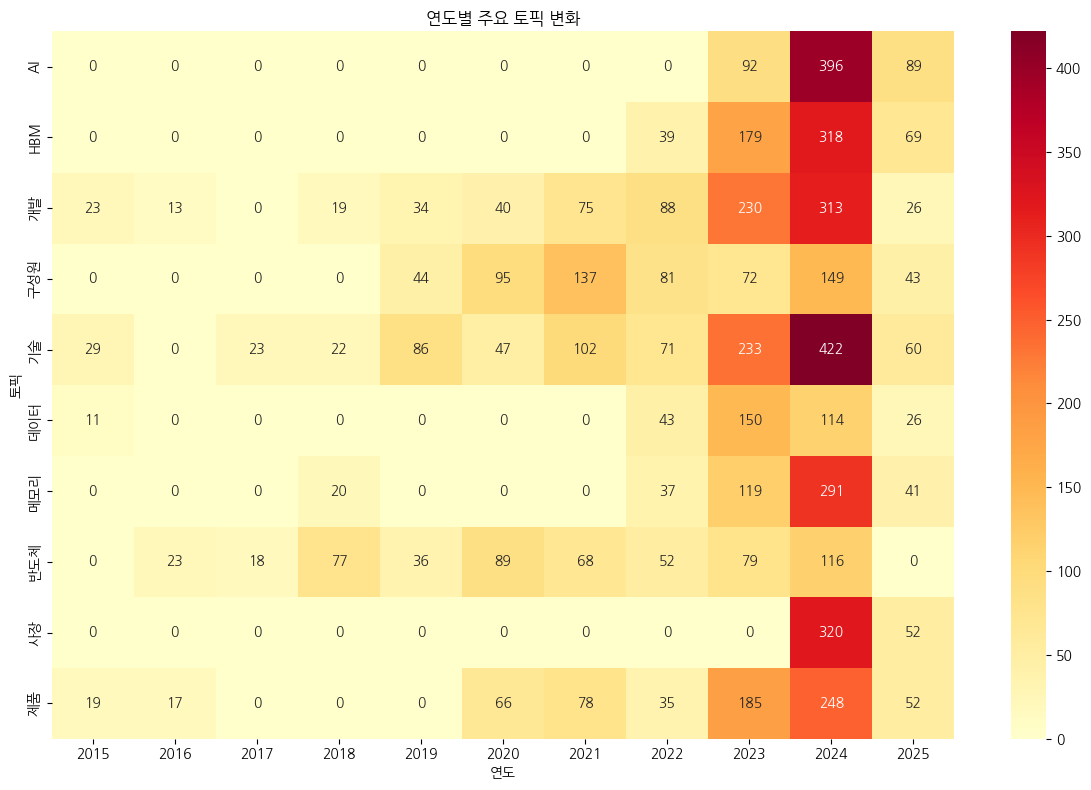

In [12]:
# 연도별 토픽 분석
print("\n연도별 토픽 분석을 시작합니다...")

# 연도별로 데이터 그룹화
df['year'] = df['date'].dt.year
yearly_groups = df.groupby('year')

# 제거할 단어 목록
remove_words = {'있', '하', '되', '받', '팀', '같', '없', '일', '때', '많', '물', '부','하이닉스','존','앞'}

# 연도별 토픽 분석 결과를 저장할 딕셔너리
yearly_topics = {}

# 각 연도별로 토픽 분석 수행
for year, group in yearly_groups:
    print(f"\n{year}년도 토픽 분석:")
    
    # 이미 전처리된 텍스트 사용
    processed_texts = group['processed_content'].str.split().explode().tolist()
    
    # 제거할 단어 필터링
    processed_texts = [word for word in processed_texts if word not in remove_words]
    
    # 단어 빈도수 계산
    word_freq = Counter(processed_texts)
    
    # 상위 20개 토픽 추출
    top_topics = word_freq.most_common(20)
    
    # 결과 저장
    yearly_topics[year] = top_topics
    
    # 결과 출력
    print(f"상위 20개 토픽:")
    for topic, count in top_topics:
        print(f"{topic}: {count}회")

# 연도별 토픽 변화 시각화
plt.figure(figsize=(15, 8))
years = list(yearly_topics.keys())
topics = set()
for year_topics in yearly_topics.values():
    topics.update([topic for topic, _ in year_topics])

# 연도별 토픽 빈도수 데이터프레임 생성
topic_data = []
for year in years:
    year_topics = dict(yearly_topics[year])
    for topic in topics:
        topic_data.append({
            'year': year,
            'topic': topic,
            'count': year_topics.get(topic, 0)
        })

topic_df = pd.DataFrame(topic_data)

# 상위 10개 토픽만 선택
top_10_topics = topic_df.groupby('topic')['count'].sum().nlargest(10).index
topic_df = topic_df[topic_df['topic'].isin(top_10_topics)]

# 히트맵 생성
pivot_df = topic_df.pivot(index='topic', columns='year', values='count')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('연도별 주요 토픽 변화')
plt.xlabel('연도')
plt.ylabel('토픽')
plt.tight_layout()
plt.show()